In [1]:
# ! wget https://www.dropbox.com/s/enhn27b8th5b20x/x_test32_3.npy?dl=0 -O x_test32_3.npy
# ! wget https://www.dropbox.com/s/22ew3bhmid01aup/x_train32_3.npy?dl=0 -O x_train32_3.npy

In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [3]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
NUM_CLASS = 10
IMG_SHAPE = (32,32,3)
BATCH_SIZE = 265
EPOCHS = 50

In [5]:
x_train = np.load('x_train32_3.npy')
x_test = np.load('x_test32_3.npy')

In [6]:
(_, y_train), (_, y_test) = mnist.load_data()

In [7]:
resnet = keras.applications.ResNet50V2(include_top=False,
                                       weights=None,
                                       input_shape=IMG_SHAPE,
                                       pooling='avg')

In [8]:
inputs = keras.Input(shape=IMG_SHAPE)
outputs = resnet(inputs)
encoder = keras.Model(inputs, outputs, name='my-encoder')

In [9]:
encoder.summary()

Model: "my-encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 2048)              23564800  
Total params: 23,564,800
Trainable params: 23,519,360
Non-trainable params: 45,440
_________________________________________________________________


In [10]:
features = encoder(inputs)   # todo: single model encoder + classifier
features = layers.Dropout(0.5)(features)
features = layers.Dense(512, activation='relu')(features) 
features = layers.Dropout(0.5)(features)
outputs = layers.Dense(10, activation='softmax')(features)
model = keras.Model(inputs, outputs, name='my-classifier' )

In [11]:
model.compile(optimizer='adam', 
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

In [12]:
model.loss.get_config()

{'from_logits': False,
 'name': 'sparse_categorical_crossentropy',
 'reduction': 'auto'}

In [13]:
model.optimizer.get_config()

{'amsgrad': False,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'decay': 0.0,
 'epsilon': 1e-07,
 'learning_rate': 0.001,
 'name': 'Adam'}

In [14]:
model.summary()

Model: "my-classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
my-encoder (Functional)      (None, 2048)              23564800  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 24,619,018
Trainable params: 24,573,578
Non-trainable params: 45,440
____________________________________

In [15]:
train_gen = ImageDataGenerator( # rescale=1./255,
                               rotation_range=15,
                               width_shift_range=0.2,
                               height_shift_range=0.1,
                               zoom_range=0.1)

In [16]:
training_set = train_gen.flow(x_train,y_train,batch_size=BATCH_SIZE)

In [17]:
test_set = train_gen.flow(x_test,y_test,batch_size=BATCH_SIZE)

In [18]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                               patience=3)

In [19]:
history = model.fit(training_set, 
                    validation_data=test_set,
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS,
                    # callbacks=[es_callback]
                    )

Epoch 1/50
227/227 [==============================] - 47s 158ms/step - loss: 0.5527 - sparse_categorical_accuracy: 0.8319 - val_loss: 0.1676 - val_sparse_categorical_accuracy: 0.9481
Epoch 2/50
227/227 [==============================] - 31s 138ms/step - loss: 0.1402 - sparse_categorical_accuracy: 0.9604 - val_loss: 0.1338 - val_sparse_categorical_accuracy: 0.9605
Epoch 3/50
227/227 [==============================] - 31s 138ms/step - loss: 0.1003 - sparse_categorical_accuracy: 0.9717 - val_loss: 0.1600 - val_sparse_categorical_accuracy: 0.9583
Epoch 4/50
227/227 [==============================] - 31s 137ms/step - loss: 0.0851 - sparse_categorical_accuracy: 0.9767 - val_loss: 0.0916 - val_sparse_categorical_accuracy: 0.9743
Epoch 5/50
227/227 [==============================] - 31s 137ms/step - loss: 0.0737 - sparse_categorical_accuracy: 0.9799 - val_loss: 0.0714 - val_sparse_categorical_accuracy: 0.9777
Epoch 6/50
227/227 [==============================] - 31s 137ms/step - loss: 0.0618 -

In [20]:
model.save('cl_augm_my_c2.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [21]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 6s 14ms/step - loss: 0.0227 - sparse_categorical_accuracy: 0.9938


[0.022721901535987854, 0.9937999844551086]

In [22]:
model.evaluate(x_train, y_train)

1875/1875 [==============================] - 24s 13ms/step - loss: 0.0153 - sparse_categorical_accuracy: 0.9951


[0.015273301862180233, 0.9950833320617676]

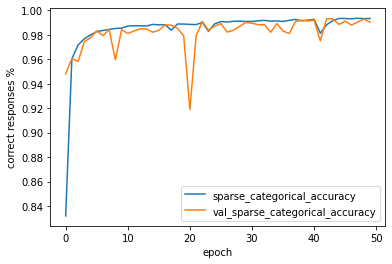

In [23]:
plt.plot(history.history['sparse_categorical_accuracy'],
         label='sparse_categorical_accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'],
         label='val_sparse_categorical_accuracy')
plt.xlabel('epoch')
plt.ylabel('correct responses %')
plt.legend()
plt.show()

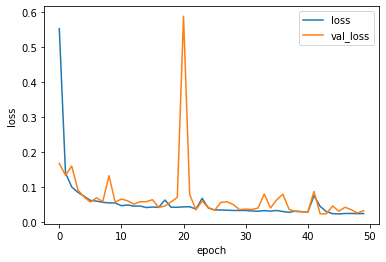

In [24]:
plt.plot(history.history['loss'],
         label='loss')
plt.plot(history.history['val_loss'],
         label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [25]:
! cp cl_augm_my_c2.h5 /content/gdrive/My\ Drive/ 